In [1]:
%load_ext autoreload
%autoreload 2

In [52]:
from bitcoin_deep_learning.call_api import ApiCall
from bitcoin_deep_learning.metrics import *
from bitcoin_deep_learning.model import LinearRegressionBaselineModel
from bitcoin_deep_learning.cross_val import cross_val_trade
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [3]:
! pwd

/Users/alexandrelaizet/code/AlexandreLaizet/bitcoin_deep_learning/notebooks


In [4]:
df = ApiCall().read_local(data="train")

In [5]:
df

,date,[AVG]_[NH]_mean_hash_rate,[+]_[NH]_Days_Till_Halving,[//]_[AV]_Stock-to-Flow_Ratio,[+]_[NH]_Circulating_Supply,[+]_[NH]_Issuance,[+]_[NH]_Number_of_Active_Addresses,[+]_[NH]_Mean_Block_Interval,[+]_[NH]_Number_of_Transactions,[+]_[NH]_Number_of_Addresses_with_a_Non-Zero_Balance,...,[%]_Bitcoin_growth_rate_on_Horizon=7,fear_greed_value,[+]_[NH]_Number_of_Addresses_with_Balance_0.01 - 0.1,[+]_[NH]_Number_of_Addresses_with_Balance_0.1 - 1,[+]_[NH]_Number_of_Addresses_with_Balance_1 - 10,[+]_[NH]_Number_of_Addresses_with_Balance_10 - 100,[+]_[NH]_Number_of_Addresses_with_Balance_100 - 1k,[+]_[NH]_Number_of_Addresses_with_Balance_1k - 10k,[+]_[T]_Bitcoin_Price,[%]_Bitcoin_growth_rate_on_Horizon=7.1
0,2018-02-01,2.054109e+19,830,5642.903220,16839700.00,2000.00,842398,377,257504,27026398,...,-0.096230,30,4226306,1722331,544769,132314,15779,1529,9014.026207,-0.096230
1,2018-02-02,2.170824e+19,829,5641.695528,16841800.00,2100.00,854253,385,235750,26955617,...,-0.013968,15,4198274,1704275,543489,132213,15815,1521,8799.121911,-0.013968
2,2018-02-03,2.073919e+19,828,5641.015128,16843775.00,1975.00,714655,384,194733,26886977,...,-0.078603,40,4173275,1692828,542447,132021,15812,1523,9208.459919,-0.078603
3,2018-02-04,2.280248e+19,827,5632.191528,16846000.00,2225.00,720904,349,173509,26753036,...,-0.012779,24,4103680,1674480,540698,132009,15830,1532,8176.460616,-0.012779
4,2018-02-05,2.411984e+19,826,5626.186626,16848312.50,2312.50,903239,338,216178,26562089,...,0.224166,11,4036425,1668996,541030,131987,15813,1519,6891.934414,0.224166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401,2021-12-03,1.895333e+20,877,107683.375209,18890443.75,1050.00,1009846,335,289971,39196439,...,-0.137606,31,6033537,2468409,663251,132374,13950,2057,53765.796483,-0.137606
1402,2021-12-04,1.690595e+20,876,107627.370170,18891412.50,968.75,966373,365,253519,39269124,...,0.007926,25,6045160,2473113,664015,132441,13979,2061,48962.920993,0.007926
1403,2021-12-05,1.869669e+20,875,107497.322411,18892450.00,1037.50,966666,342,215047,39150342,...,0.018836,18,6056667,2476280,664358,132558,13969,2067,49174.902908,0.018836
1404,2021-12-06,1.883618e+20,874,107272.444575,18893525.00,1075.00,1059561,358,284295,39078981,...,-0.079764,16,6056432,2478318,664726,132764,13971,2059,50492.435596,-0.079764


In [6]:
model = LinearRegressionBaselineModel(alpha = 0.05 , l1_ratio = 0.0001)
roi_hodler, roi_trader, roi_whale, roi_hodler_whale, roi_charles, sharpe_hodler, sharpe_trader, sharpe_whale, sharpe_hodler_whale, sharpe_charles = iterate_cross_val_results(model = model)
print("---")
print("Hodler roi: ", roi_hodler)
print("Hodler sharpe ratio: ", sharpe_hodler)
print("---")
print("Trader roi: ", roi_trader)
print("Trader sharpe ratio: ", sharpe_trader)
print("---")
print("Whale roi: ", roi_whale)
print("Whale sharpe ratio: ", sharpe_whale)
print("---")
print("Hodler whale roi: ", roi_hodler_whale)
print("Hodler whale sharpe ratio: ", sharpe_hodler_whale)
print("---")
print("Charles roi: ", roi_charles)
print("Charles sharpe ratio: ", sharpe_charles)

---
Hodler roi:  0.07606282088812734
Hodler sharpe ratio:  2.692378821921656
---
Trader roi:  -0.012438564785148456
Trader sharpe ratio:  -0.7122943147130746
---
Whale roi:  -0.01882928103769756
Whale sharpe ratio:  -0.52968939603384
---
Hodler whale roi:  -0.01882928103769756
Hodler whale sharpe ratio:  -0.52968939603384
---
Charles roi:  0.10044636609458985
Charles sharpe ratio:  2.303682663989103


In [58]:
def iterate_portfolio_positions(model = LinearRegressionBaselineModel(alpha = 0.05 , l1_ratio = 0.0001), df = df):

    portfolio_positions_hodler = []
    portfolio_positions_trader = []
    portfolio_positions_whale = []
    portfolio_positions_hodler_whale = []
    portfolio_positions_charles = []

    past_realities, realities, realities_diff, prediction_diff = cross_val_trade(model, df)
    ct = 0
    preds = []
    preds_arr = []
    
    for past_prices, diffs in zip(past_realities,prediction_diff):
        for diff in diffs:
            preds.append(past_prices[ct] + past_prices[ct] * diff)
            ct += 1
        preds_arr.append(np.array(preds))
        preds.clear()
        ct = 0

    for reality, prediction in zip(realities, preds_arr):
        y_true, y_pred = reality, prediction
        
        portfolio_positions_hodler.append(play_hodler_strategy(y_true, y_pred))
        portfolio_positions_trader.append(play_trader_strategy(y_true, y_pred))
        portfolio_positions_whale.append(play_whale_strategy(y_true, y_pred))
        portfolio_positions_hodler_whale.append(play_hodler_whale_strategy(y_true, y_pred))
        portfolio_positions_charles.append(play_charles_strategy(y_true, y_pred))

    return portfolio_positions_hodler, portfolio_positions_trader, portfolio_positions_whale, portfolio_positions_hodler_whale, portfolio_positions_charles



In [59]:
hodler, trader, whale, hodler_whale, charles = iterate_results()

In [60]:
def plot_portolio_positions(positions=iterate_results(model = LinearRegressionBaselineModel(alpha = 0.05 , l1_ratio = 0.0001), df = df)): 
    
    hodler, trader, whale, hodler_whale, charles = positions
    
    figure(figsize=(10, 6), dpi=100)

    plt.plot(hodler[0][:-1], label="Hodler")
    plt.plot(trader[0][:-1], label="Trader")
    #plt.plot(whale[0], label="Whale")
    #plt.plot(hodler_whale[0], label="Hodler whale")
    plt.plot(charles[0][:-1], label="Charles")

    plt.title("Investment strategies' results by investment strategy")
    plt.xlabel("Days")
    plt.ylabel("USD portfolio value")
    plt.legend();

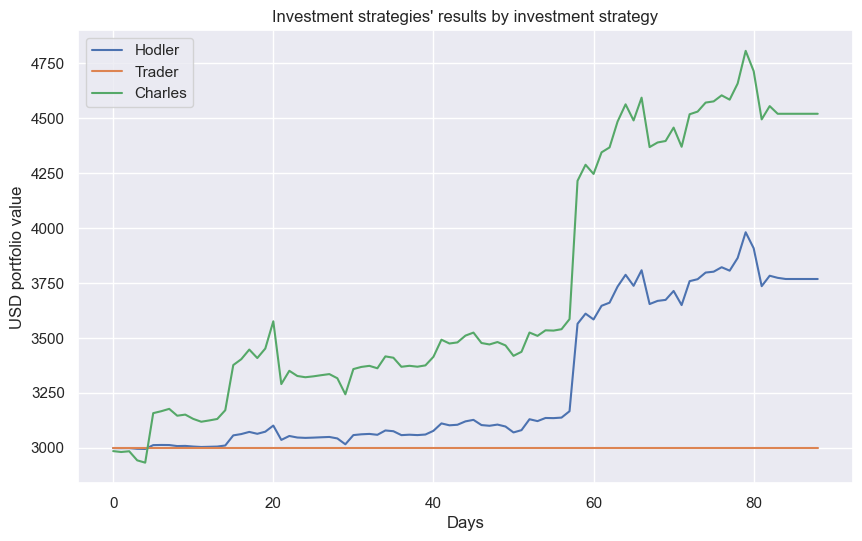

In [61]:
plot_portolio_positions(positions=iterate_results(model = LinearRegressionBaselineModel(alpha = 0.05 , l1_ratio = 0.0001), df = df))